# Análise de Dados das Corridas de Táxi em NY

Este notebook realiza uma análise completa dos dados de corridas de táxis amarelos, processados e armazenados na tabela `ifood_challenge.yellow_taxi_trips`.

A análise está dividida em duas partes:
1.  **Análise Exploratória de Dados (EDA):** Para entender a estrutura, qualidade e distribuição dos dados.
2.  **Respostas às Perguntas de Negócio:** Para extrair insights específicos com o suporte de visualizações gráficas.

## 1. Análise Exploratória de Dados (EDA)

Nesta seção, vamos carregar a tabela e investigar suas principais características.

In [0]:
%python
# Importando bibliotecas necessárias para visualização
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurando o estilo dos gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Carregando a tabela para um DataFrame do Spark
table_name = "ifood_challenge.yellow_taxi_trips"
df = spark.table(table_name)

### 1.1. Schema e Amostra dos Dados
Vamos verificar o schema da tabela para confirmar os tipos de dados e visualizar algumas linhas para entender a estrutura.

In [0]:
%python
print("Schema da tabela:")
df.printSchema()

print("\nAmostra dos dados:")
display(df.limit(5))

Schema da tabela:
root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- total_amount: double (nullable = true)


Amostra dos dados:


vendor_id,pickup_datetime,dropoff_datetime,passenger_count,total_amount
1,2023-04-01T00:14:49.000Z,2023-04-01T00:45:01.000Z,2,39.9
2,2023-04-01T00:00:24.000Z,2023-04-01T00:56:19.000Z,1,81.8
1,2023-04-01T00:03:50.000Z,2023-04-01T00:14:42.000Z,2,18.4
1,2023-04-01T00:53:18.000Z,2023-04-01T01:01:28.000Z,1,16.0
2,2023-04-01T00:07:00.000Z,2023-04-01T00:17:16.000Z,2,17.4


### 1.2. Estatísticas Descritivas
Geramos estatísticas descritivas para as colunas numéricas para entender suas distribuições, como média, desvio padrão, mínimo e máximo.

In [0]:
%python
display(df.select("passenger_count", "total_amount").describe())

summary,passenger_count,total_amount
count,15342938,15342938
mean,1.3861681511063917,28.314188025714596
stddev,0.8815887650698842,22.5024861441197
min,1,0.0
max,9,6304.9


**Observação:** A partir das estatísticas, vemos que o `total_amount` tem um valor máximo muito alto, o que pode indicar a presença de outliers. A contagem de passageiros (`passenger_count`) parece estar dentro de uma faixa razoável após a limpeza.

### 1.3. Visualização da Distribuição de `total_amount`
Um histograma nos ajuda a visualizar a distribuição dos valores das corridas. Para uma melhor visualização, vamos filtrar valores extremos que podem ser outliers.

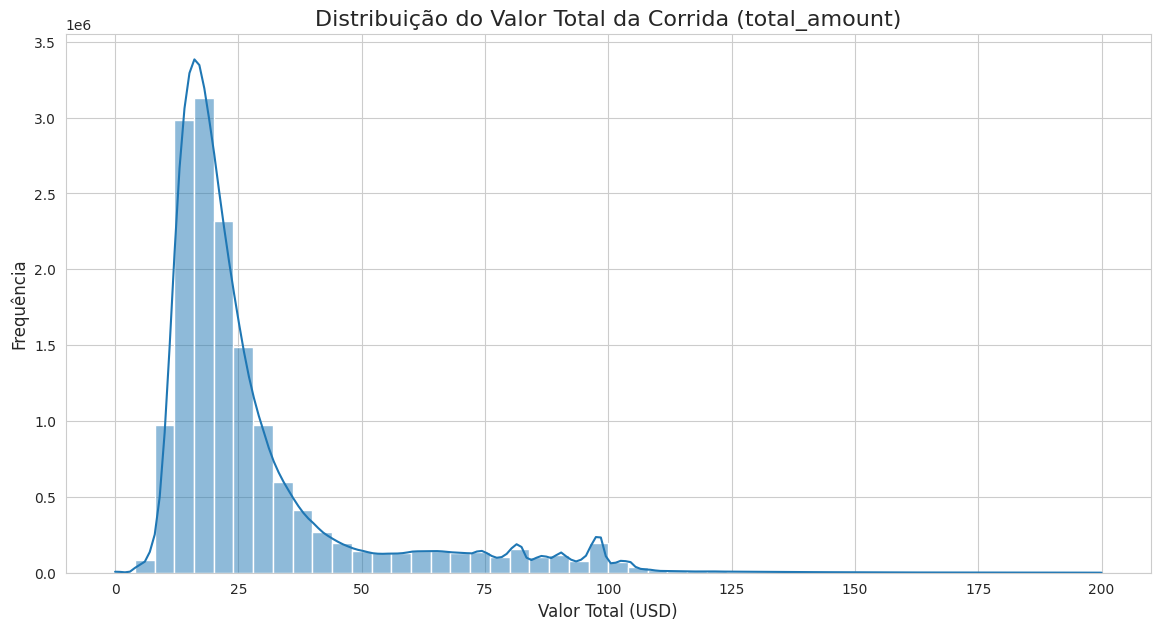

In [0]:
%python
# Convertendo para Pandas para plotagem, filtrando outliers para melhor visualização
pandas_df = df.select("total_amount").filter("total_amount >= 0 AND total_amount < 200").toPandas()

plt.figure(figsize=(14, 7))
sns.histplot(pandas_df['total_amount'], bins=50, kde=True)
plt.title('Distribuição do Valor Total da Corrida (total_amount)', fontsize=16)
plt.xlabel('Valor Total (USD)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.show()

## 2. Respostas às Perguntas de Negócio

### Pergunta 1: Qual a média de valor total (`total_amount`) recebido em um mês?

In [0]:
%sql
-- A query permanece a mesma, mas agora vamos visualizar o resultado
SELECT
  MONTH(pickup_datetime) AS mes,
  AVG(total_amount) AS media_valor_total
FROM
  ifood_challenge.yellow_taxi_trips
GROUP BY
  mes
ORDER BY
  mes;

mes,media_valor_total
1,27.4578427555988
2,27.365620957331974
3,28.284968319023605
4,28.77978497243427
5,29.449052426102384


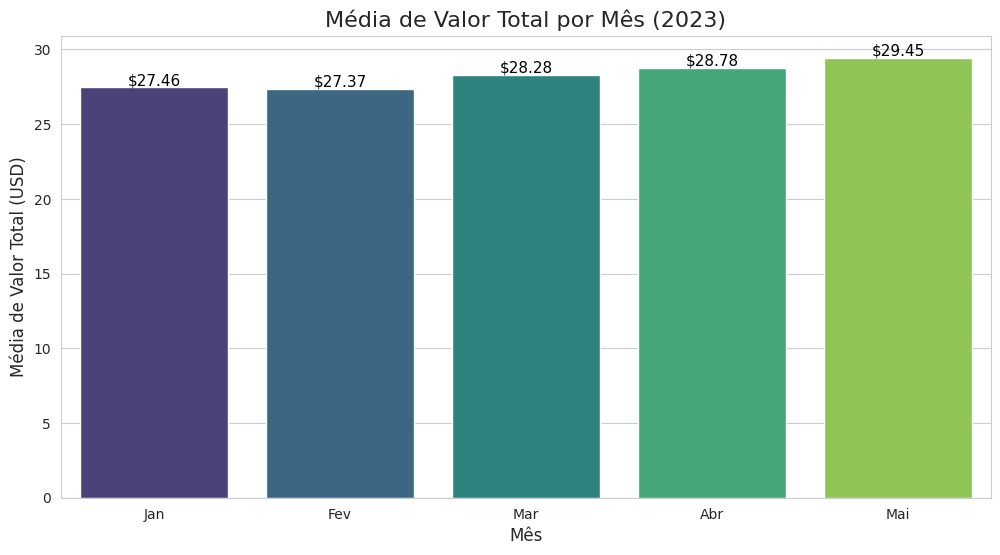

In [0]:
%python
# Obtendo o resultado da última query SQL para plotagem
result_q1_df = _sqldf
pandas_q1_df = result_q1_df.toPandas()

# Mapeando número do mês para nome
meses = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Abr', 5: 'Mai'}
pandas_q1_df['mes_nome'] = pandas_q1_df['mes'].map(meses)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='mes_nome', y='media_valor_total', data=pandas_q1_df, palette='viridis')
ax.set_title('Média de Valor Total por Mês (2023)', fontsize=16)
ax.set_xlabel('Mês', fontsize=12)
ax.set_ylabel('Média de Valor Total (USD)', fontsize=12)

# Adicionando os valores nas barras
for p in ax.patches:
    ax.annotate(f'${p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()

**Análise do Resultado:** O gráfico de barras mostra claramente um aumento progressivo na média do valor das corridas de Janeiro a Maio. Esse insight visual é muito mais rápido de absorver do que a tabela de dados.

### Pergunta 2: Qual a média de passageiros (`passenger_count`) por cada hora do dia no mês de maio?

In [0]:
%sql
SELECT
  HOUR(pickup_datetime) AS hora_do_dia,
  AVG(passenger_count) AS media_de_passageiros
FROM
  ifood_challenge.yellow_taxi_trips
WHERE
  MONTH(pickup_datetime) = 5
GROUP BY
  hora_do_dia
ORDER BY
  hora_do_dia;

hora_do_dia,media_de_passageiros
0,1.4274634212427746
1,1.4379867872044507
2,1.4552871886313288
3,1.452468956352008
4,1.4051493960584869
5,1.2842776281804693
6,1.2612818763889195
7,1.2820311563157494
8,1.2956814339935572
9,1.3120987899789809


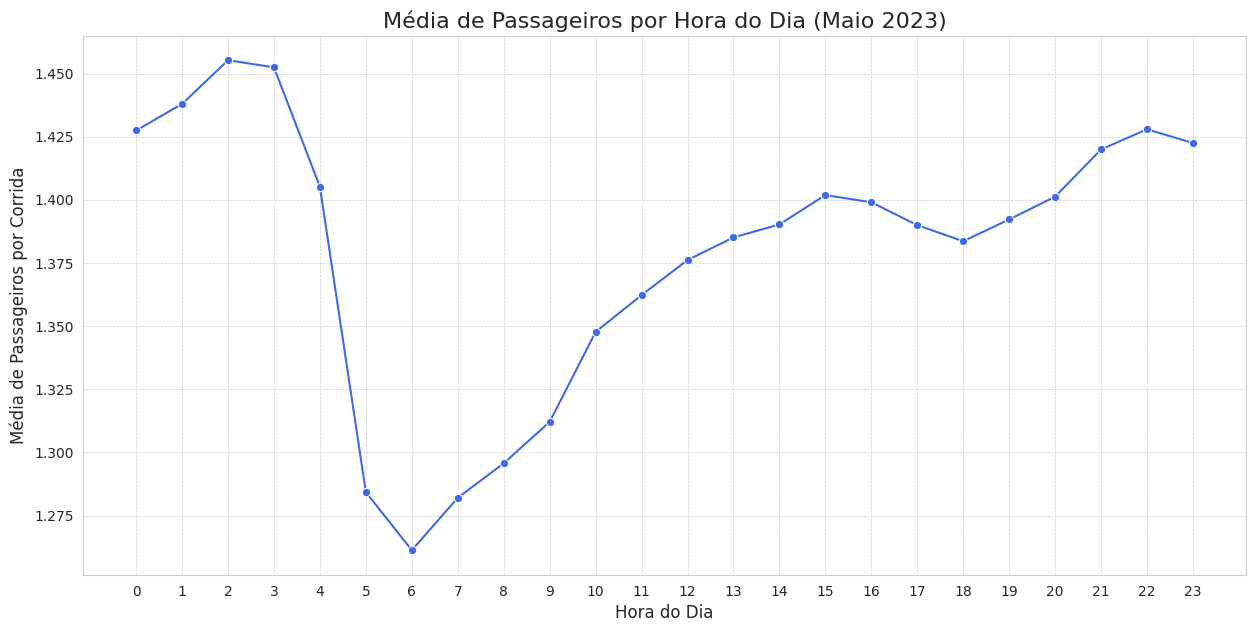

In [0]:
%python
# Obtendo o resultado da última query SQL para plotagem
result_q2_df = _sqldf
pandas_q2_df = result_q2_df.toPandas()

plt.figure(figsize=(15, 7))
ax = sns.lineplot(x='hora_do_dia', y='media_de_passageiros', data=pandas_q2_df, marker='o', color='royalblue')
ax.set_title('Média de Passageiros por Hora do Dia (Maio 2023)', fontsize=16)
ax.set_xlabel('Hora do Dia', fontsize=12)
ax.set_ylabel('Média de Passageiros por Corrida', fontsize=12)
ax.set_xticks(range(0, 24)) # Garante que todos os ticks de hora sejam mostrados
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

**Análise do Resultado:** O gráfico de linhas ilustra a dinâmica da demanda de passageiros ao longo do dia. Podemos observar uma queda na média de passageiros durante a manhã (horário comercial, possivelmente mais viagens individuais para o trabalho) e um aumento durante a noite e a madrugada, o que pode indicar um maior número de viagens de lazer em grupo.